In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ParticleFilter.Tools import resample
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')

In [2]:
Characterisation_Set = pickle.load(open("Battery_Data/new_battery_cycles/Characterisation_Set_Complete.p", 'rb'))


def scale(X):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X.min())/(X.max() - X.min()), X.min(), X.max()


def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)


SoC, SoC_min, SoC_max = scale(Characterisation_Set["SoC"].T)
Current, Current_min, Current_max = scale(Characterisation_Set["Current"].T)
# Voltage, Voltage_min, Voltage_max = scale(Characterisation_Set["Voltage"].T)
Voltage = Characterisation_Set["Voltage"].T
Characterisation_Set["preprocessing"] = {
    "SoC": (SoC_max, SoC_min),
    "Current": (Current_max, Current_min)
}

In [3]:
class RNNetwork(nn.Module):
    def __init__(self):
        super(RNNetwork, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        # SMC params
#         SoC mean: -8.131135726750027e-06
#         SoC std: 0.0002551068601502507
#         Voltage mean: 0.0033256651
#         Voltage std: 0.011334095
        self.f_mean = torch.Tensor([-8.131135726750027e-06])
        self.f_std = torch.Tensor([0.0002551068601502507])
        self.g_std = 0.011334095
        self.nu = torch.Tensor([1.0 / (self.g_std * np.sqrt(2 * np.pi))])

    def VoC(self, SoC):
        v_L = torch.Tensor([[-1.59614486]]).to(device)
        v_0 = torch.Tensor([[4.13646328]]).to(device)
        gamma = torch.Tensor([[0.63726463]]).to(device)
        alpha = torch.Tensor([[1.40174122]]).to(device)
        beta = torch.Tensor([[2.54478965]]).to(device)
        return v_L + (v_0 - v_L)*torch.exp(gamma*(SoC - 1)) + alpha*v_L*(SoC - 1) \
            + (1 - alpha)*v_L*(torch.exp(-beta) - torch.exp(-beta*torch.sqrt(SoC)))

    def forward(self, soc_init, current, voltage_measured):
        first = True
        voltage = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc_hist = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc = soc_init.to(device, torch.float)
        N = soc_init.shape[0]

        for t in range(current.shape[1]):

            # A prior estimate
            if first:
                I = torch.ones(N, 1) * current[0, t]
            else:
                I = torch.ones(N, 1) * current[0, t-1]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)
            V = self.VoC(soc) - I * Z

            # Predict SoC(t-1) -> SoC(t)
            soc = soc - I*V/Characterisation_Set['E_crit']
            # Add model uncertainty
            soc = soc + torch.normal(torch.ones([N, 1]) * self.f_mean, torch.ones([N, 1]) * self.f_std).to(device)

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            I = torch.ones(N, 1) * current[0, t]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # a Priori evidence
            V = self.VoC(soc) - I*Z

            #SMC

            W = self.nu * torch.exp(-0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0))
            logW = torch.log(self.nu) - 0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0)

            max_logW = logW.max()
            loss_W = torch.exp(logW - max_logW)

            # Resampling
            soc, W = resample(soc, loss_W)

            # Loss wrt Evidence
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Posterior evidence
            V = self.VoC(soc) - I * Z

            mse = torch.sum(torch.pow(V.to("cpu") - voltage_measured[0, t], 2.0)) / N

            if not first:
                loss = loss + (mse / current.shape[1])
            else:
                loss = (mse / current.shape[1])
                first = False

            voltage[:, t] = V[:, 0]
            soc_hist[:, t] = soc[:, 0]

        return loss, voltage, soc_hist

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vsmc = RNNetwork()

In [5]:
saved_network = "./Battery_Data/new_battery_cycles/Battery_RNN_from_prior_mse_v4"
parts = 10
N = 100

torch.Size([100, 3570])
(1, 3570)


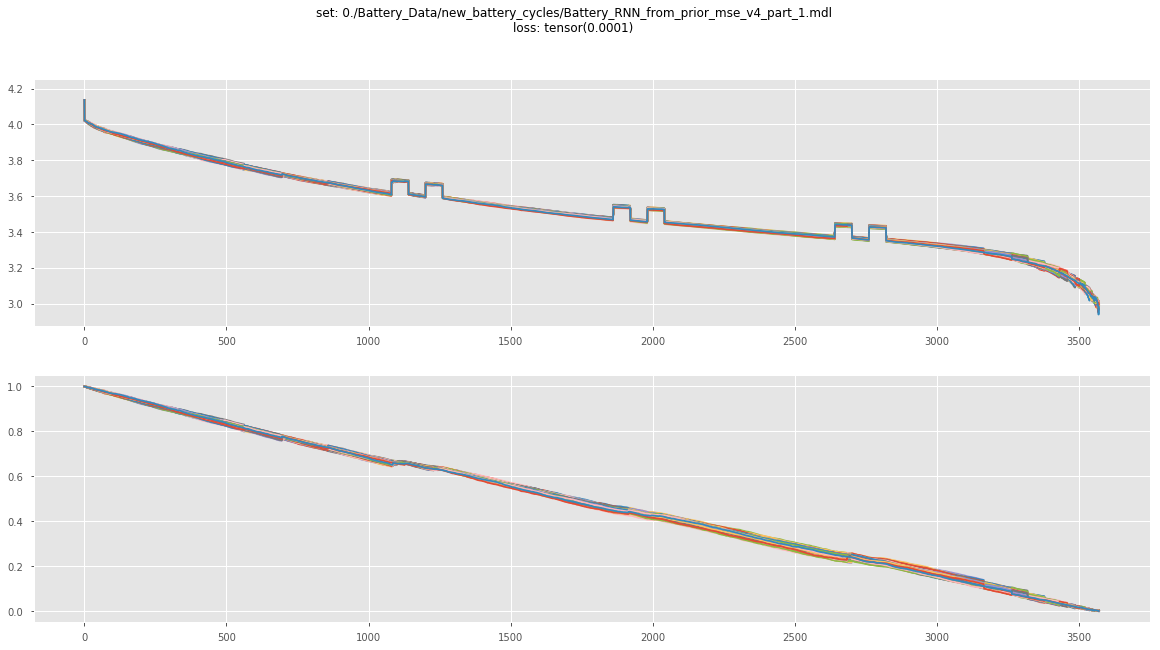

torch.Size([100, 1852])
(1, 1852)


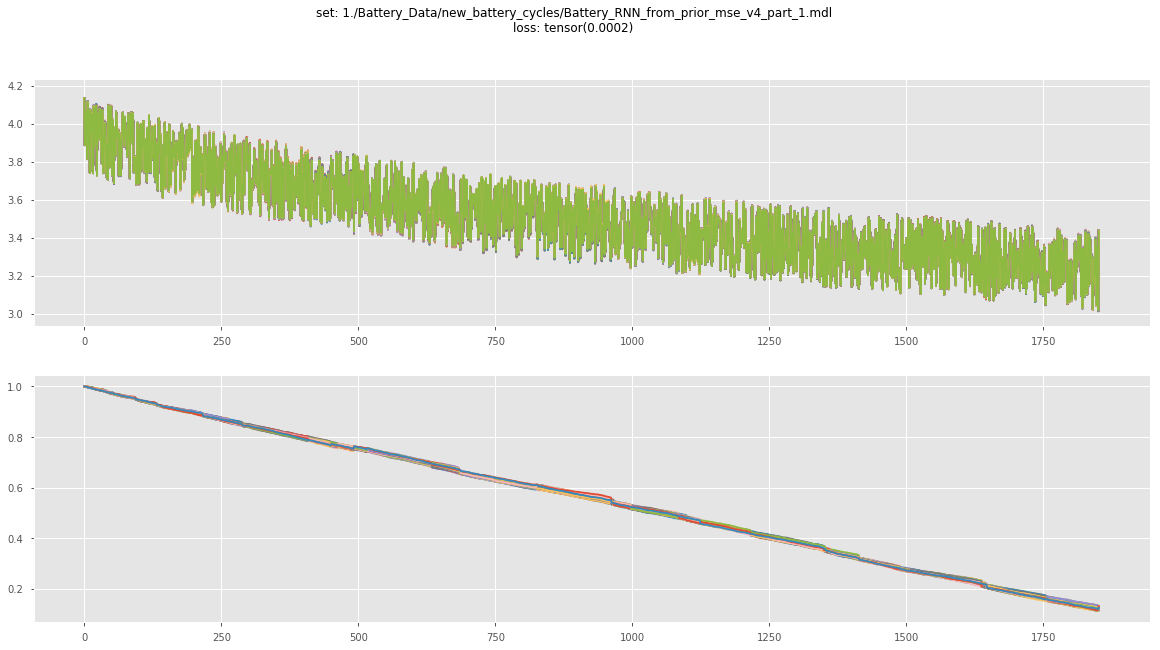

torch.Size([100, 1849])
(1, 1849)


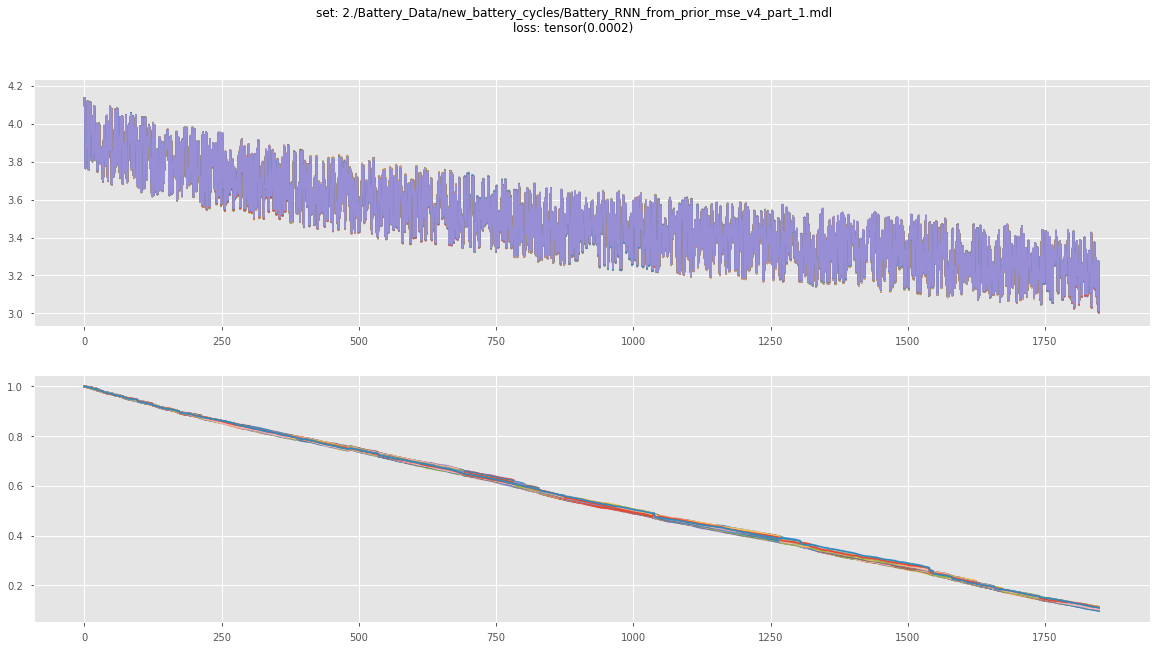

torch.Size([100, 3570])
(1, 3570)


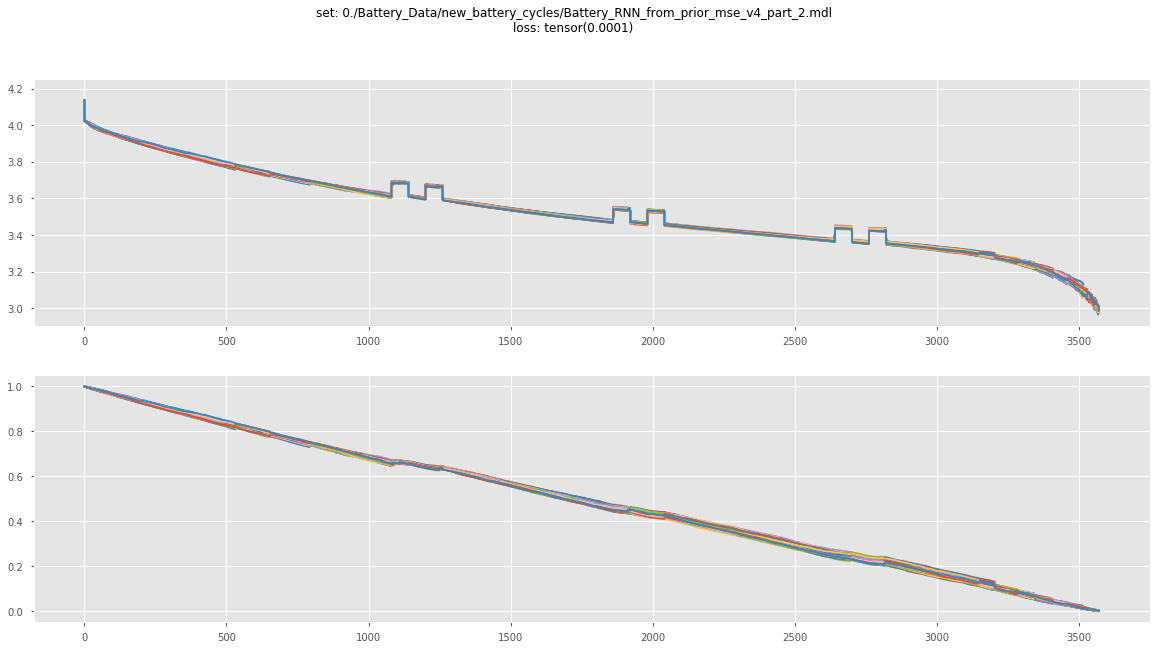

torch.Size([100, 1852])
(1, 1852)


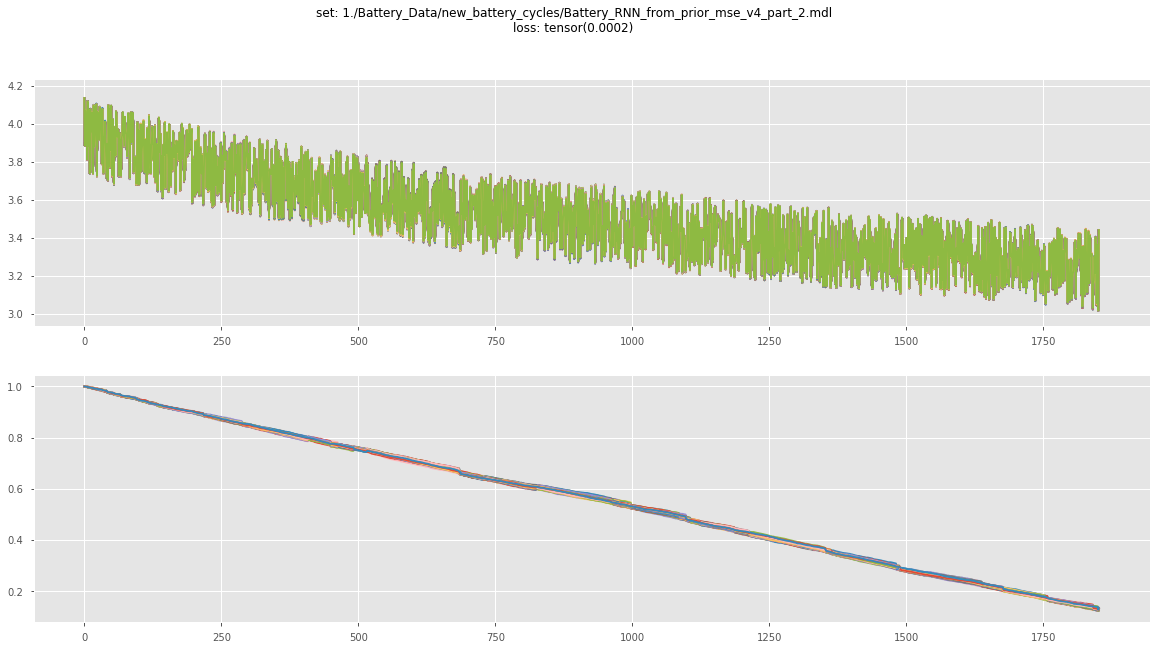

torch.Size([100, 1849])
(1, 1849)


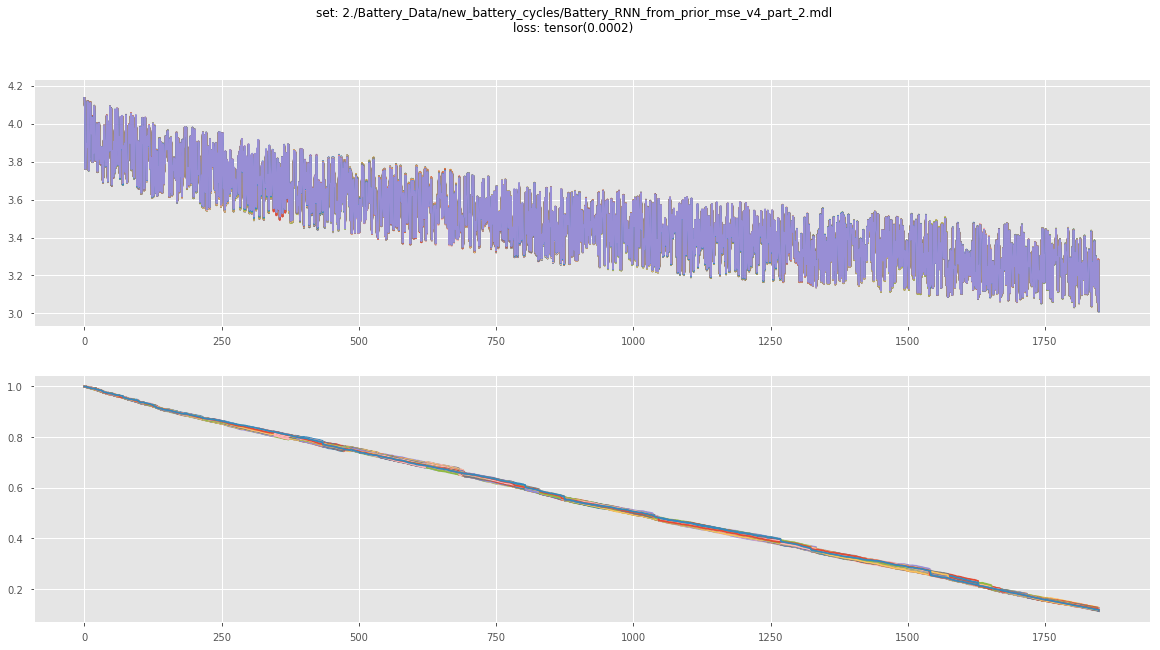

torch.Size([100, 3570])
(1, 3570)


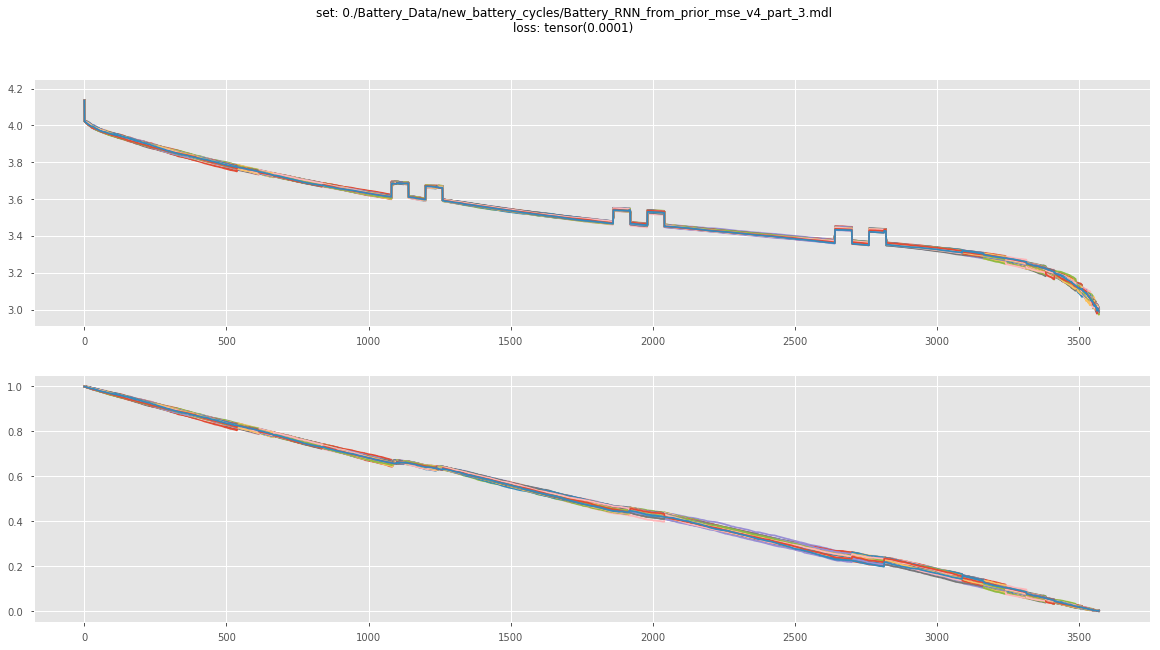

torch.Size([100, 1852])
(1, 1852)


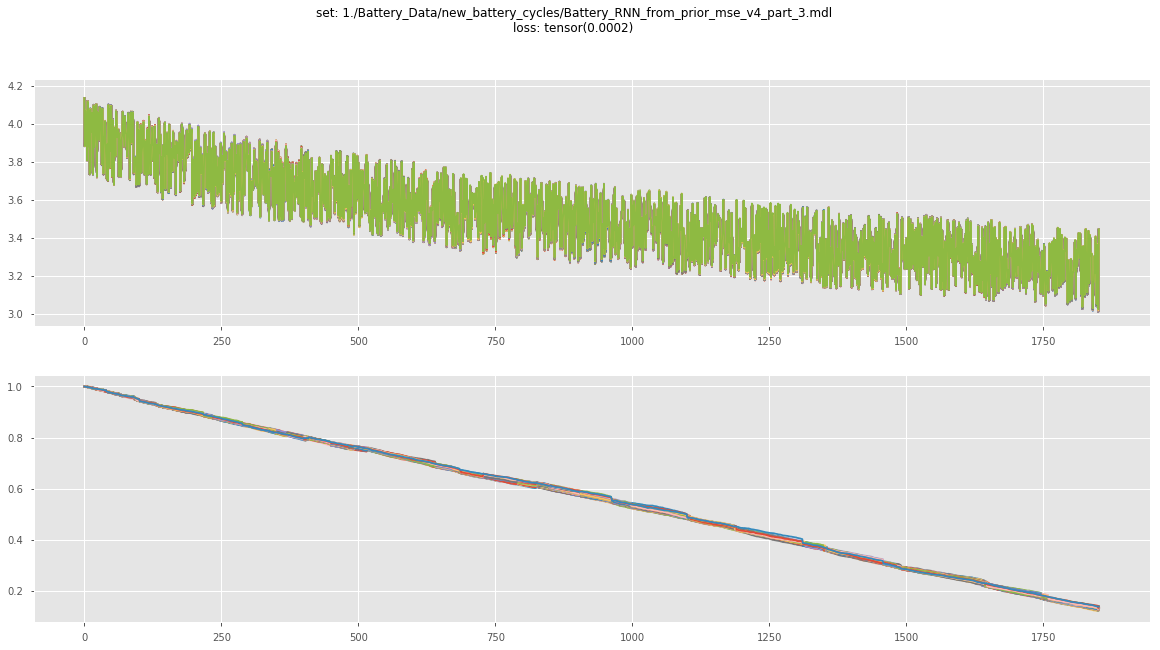

torch.Size([100, 1849])
(1, 1849)


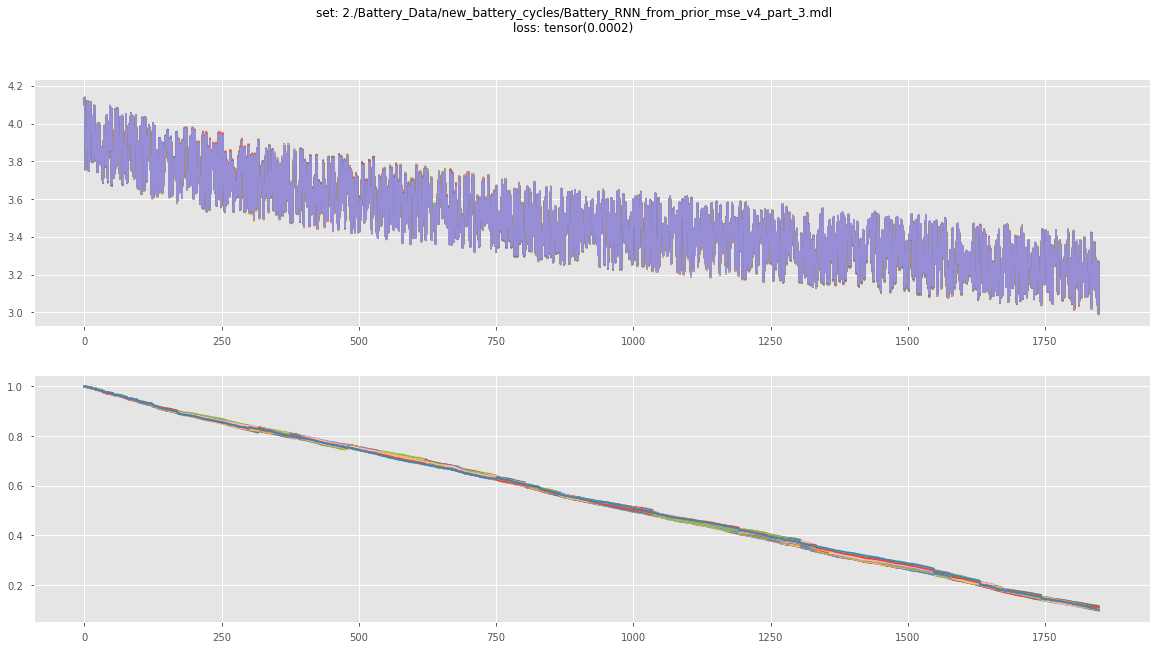

torch.Size([100, 3570])
(1, 3570)


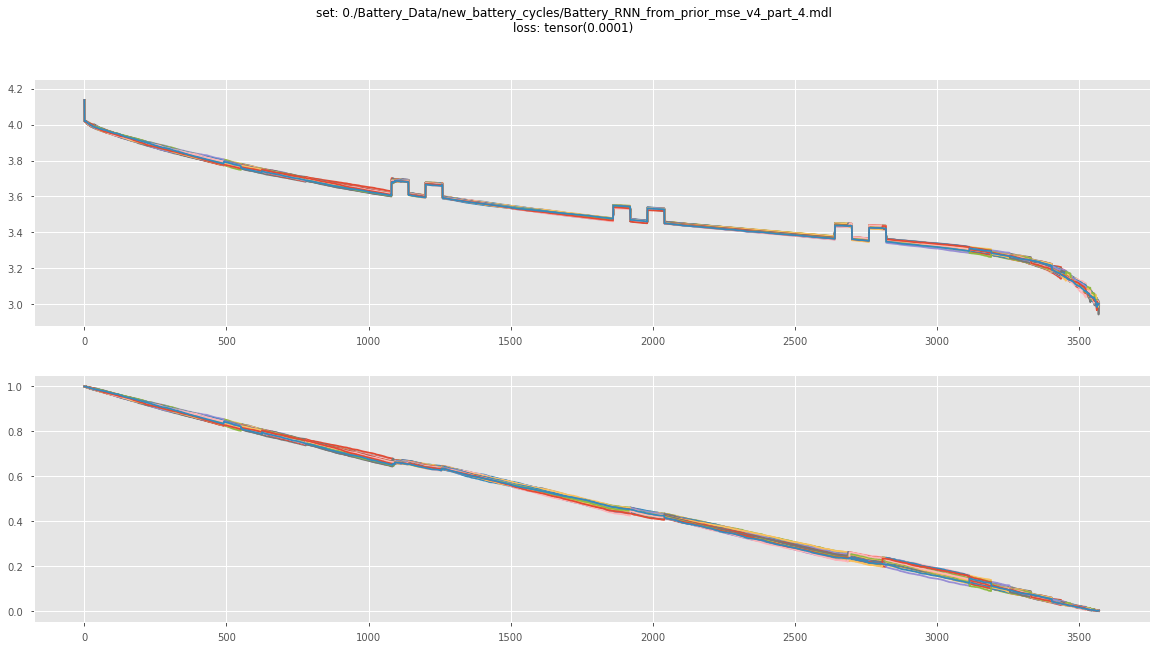

torch.Size([100, 1852])
(1, 1852)


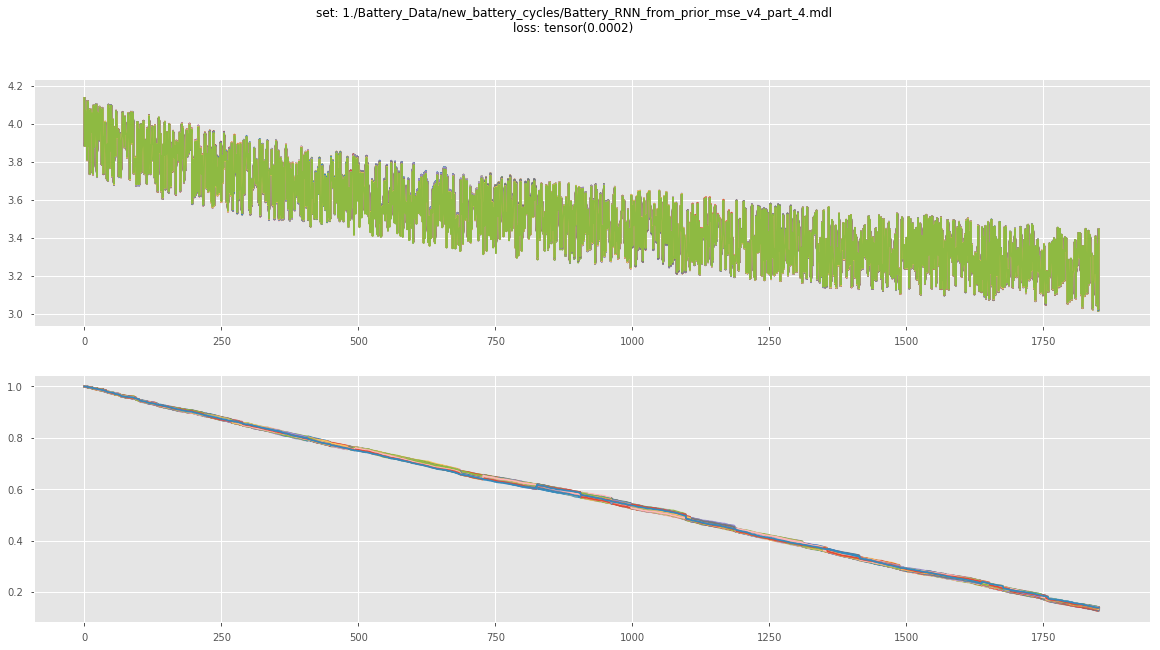

torch.Size([100, 1849])
(1, 1849)


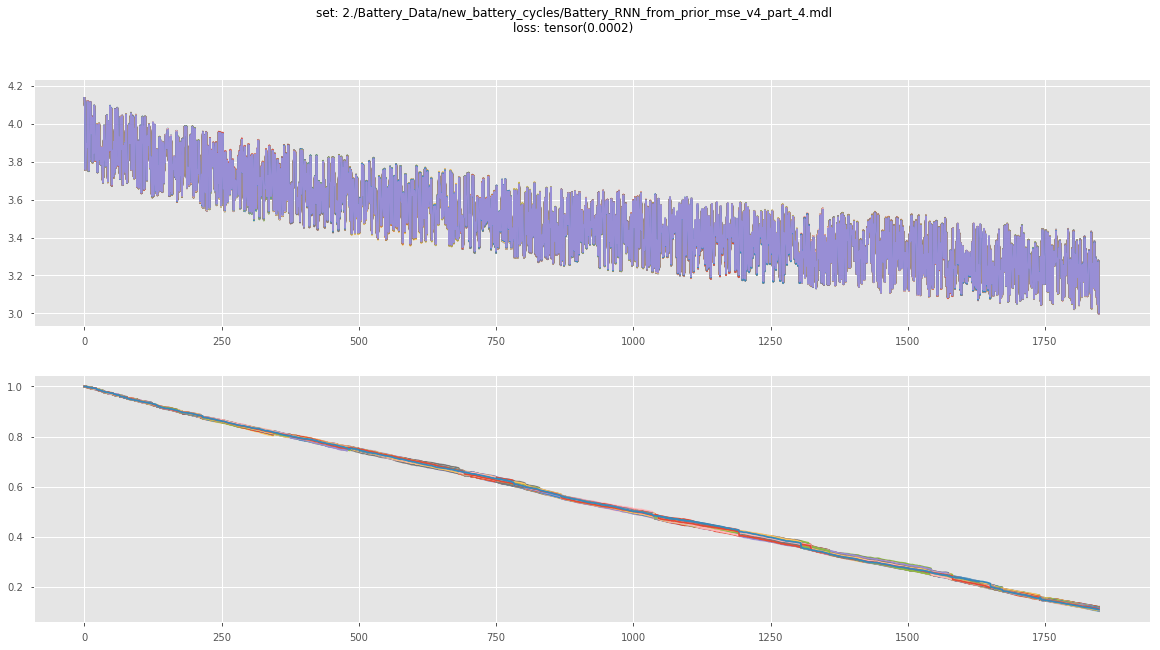

torch.Size([100, 3570])
(1, 3570)


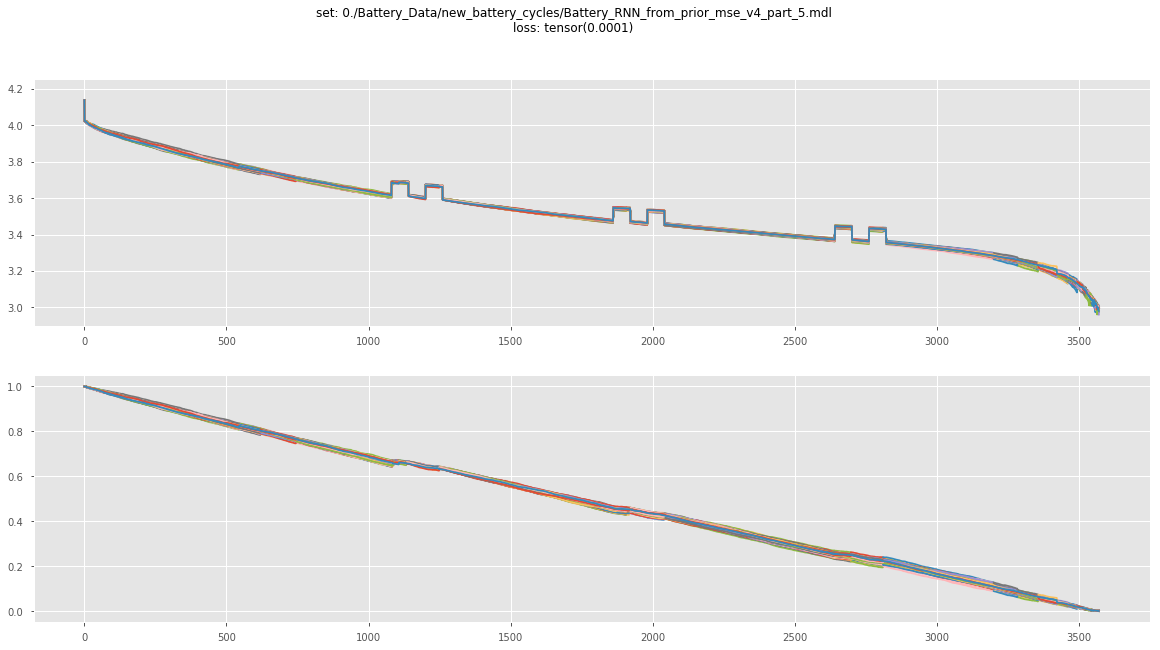

torch.Size([100, 1852])
(1, 1852)


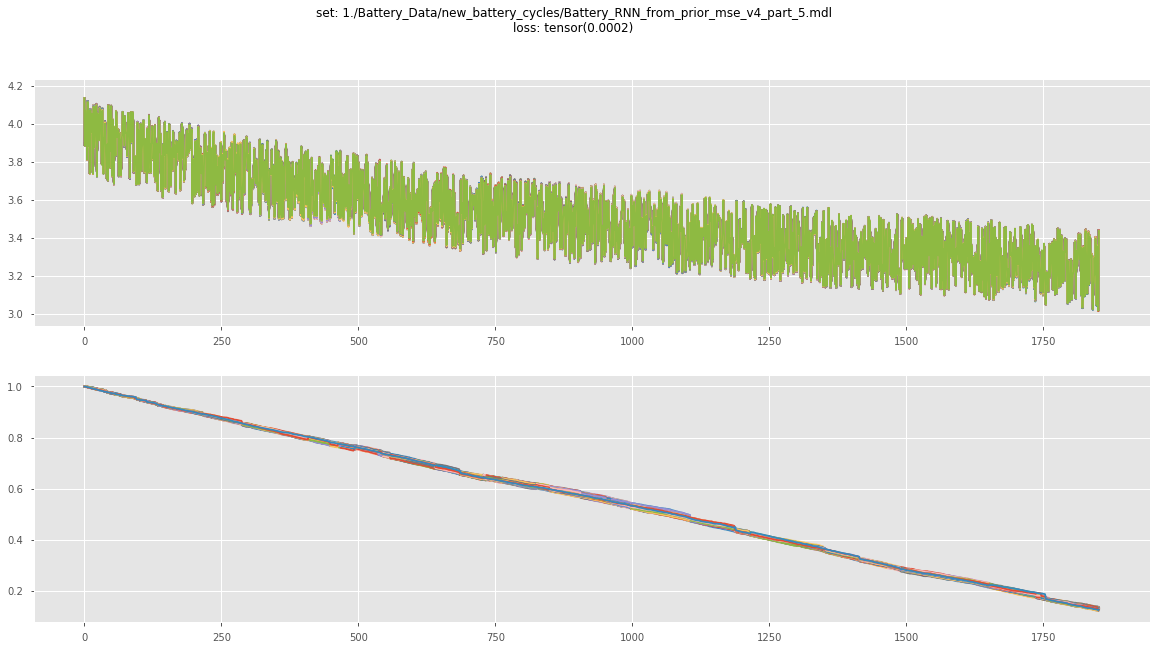

torch.Size([100, 1849])
(1, 1849)


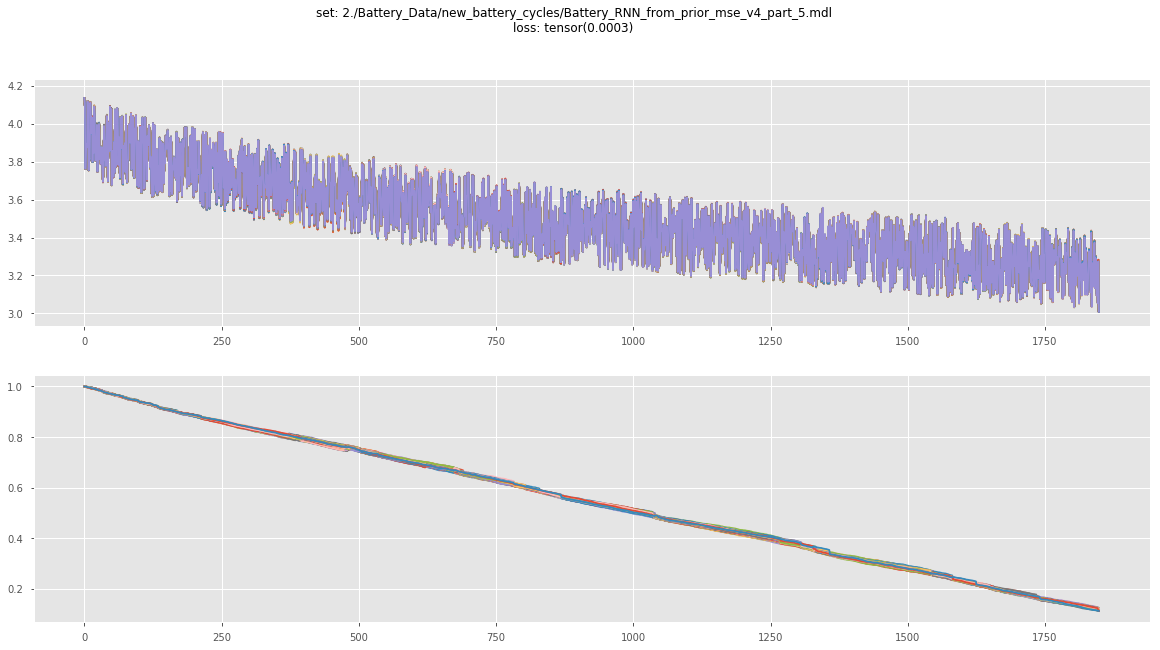

torch.Size([100, 3570])
(1, 3570)


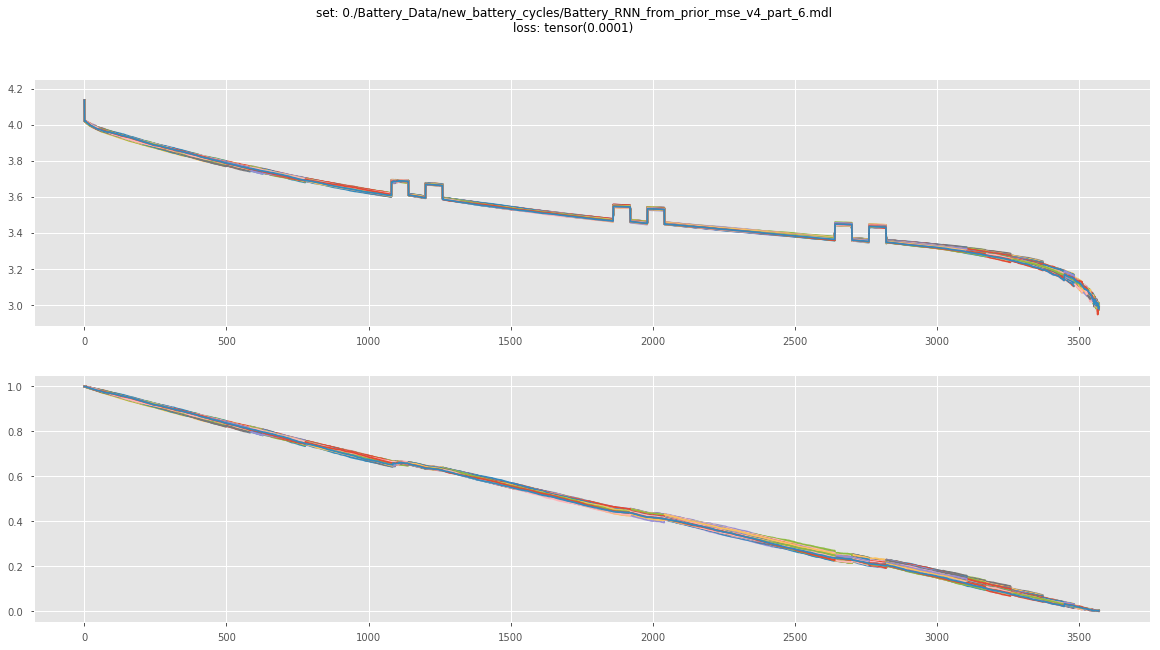

torch.Size([100, 1852])
(1, 1852)


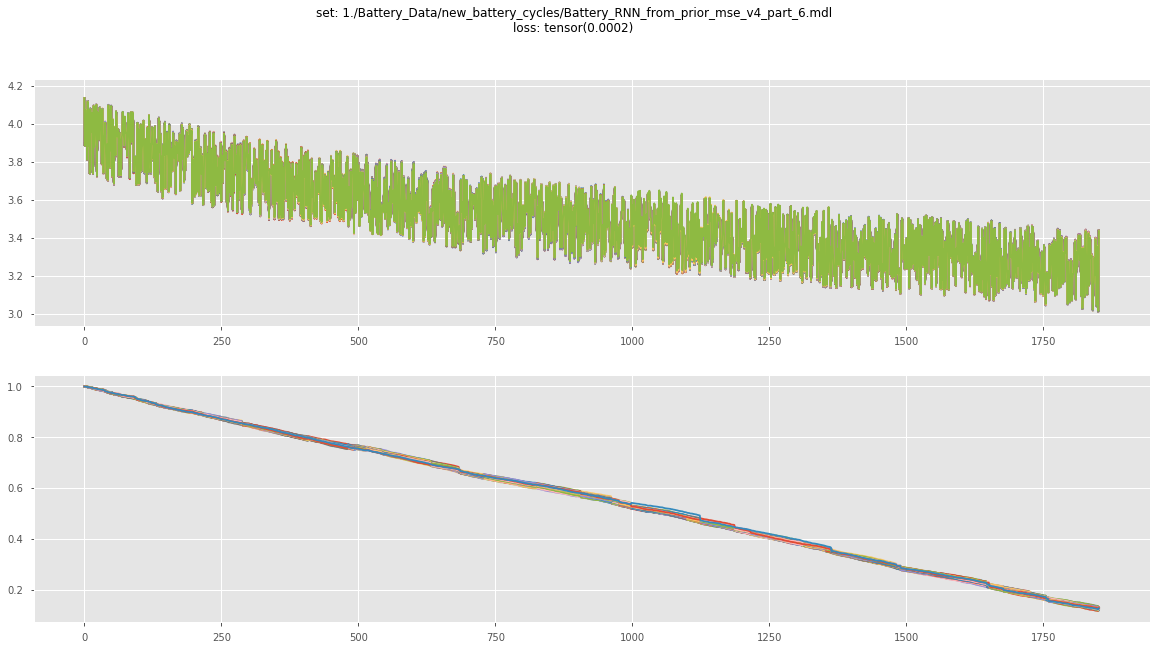

torch.Size([100, 1849])
(1, 1849)


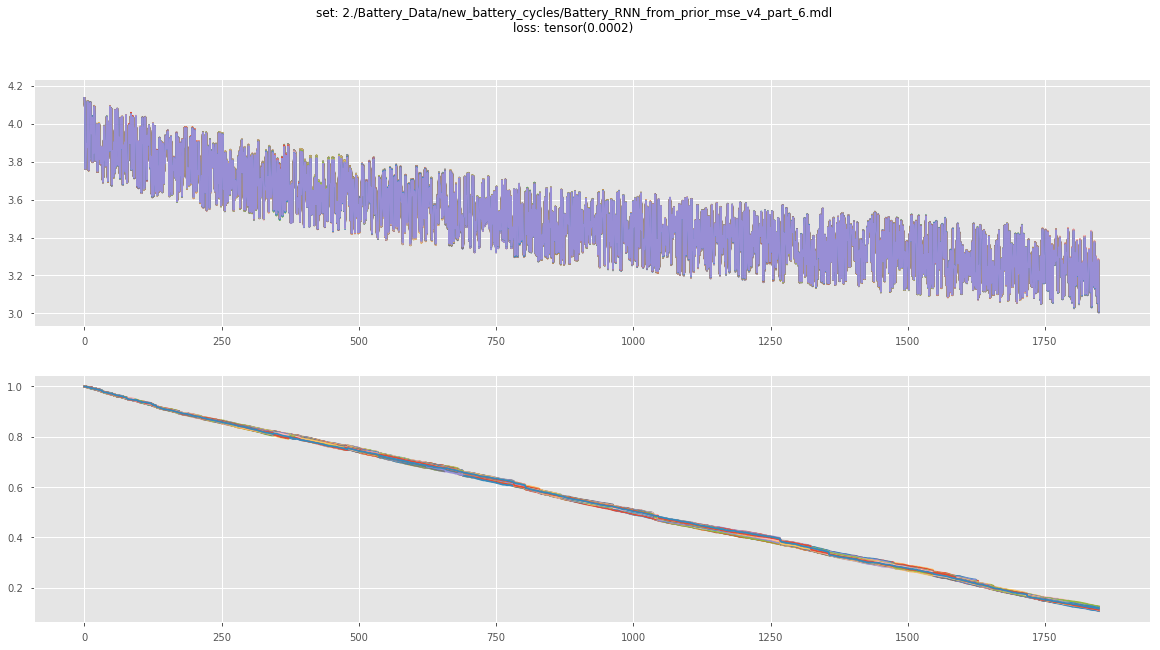

torch.Size([100, 3570])
(1, 3570)


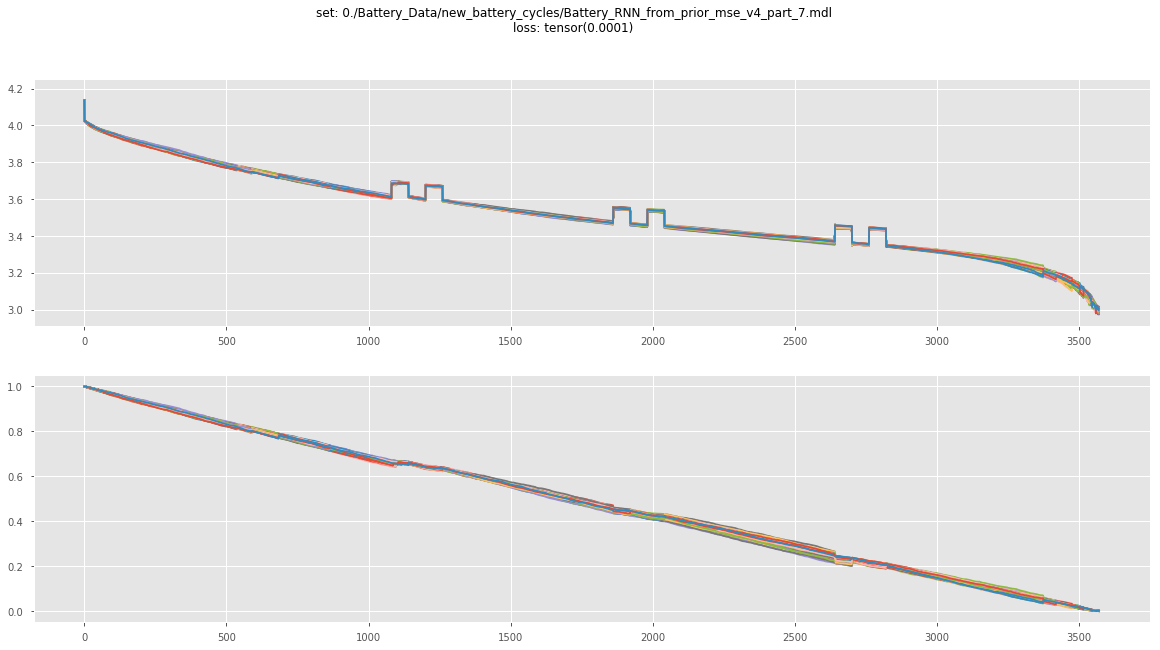

torch.Size([100, 1852])
(1, 1852)


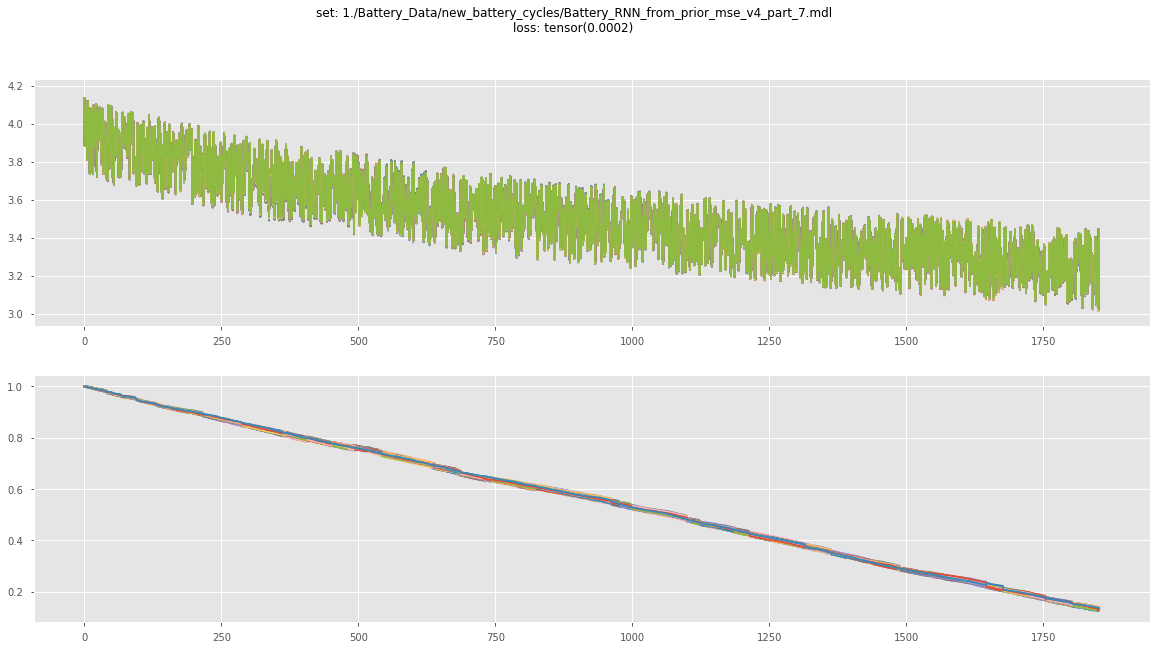

torch.Size([100, 1849])
(1, 1849)


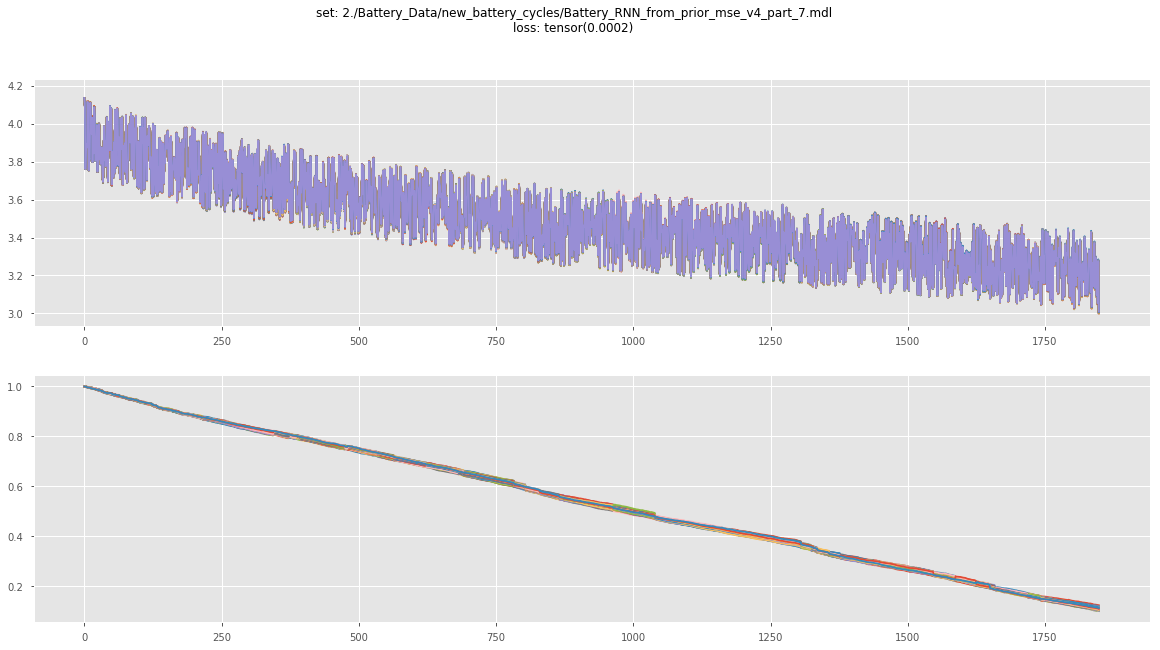

torch.Size([100, 3570])
(1, 3570)


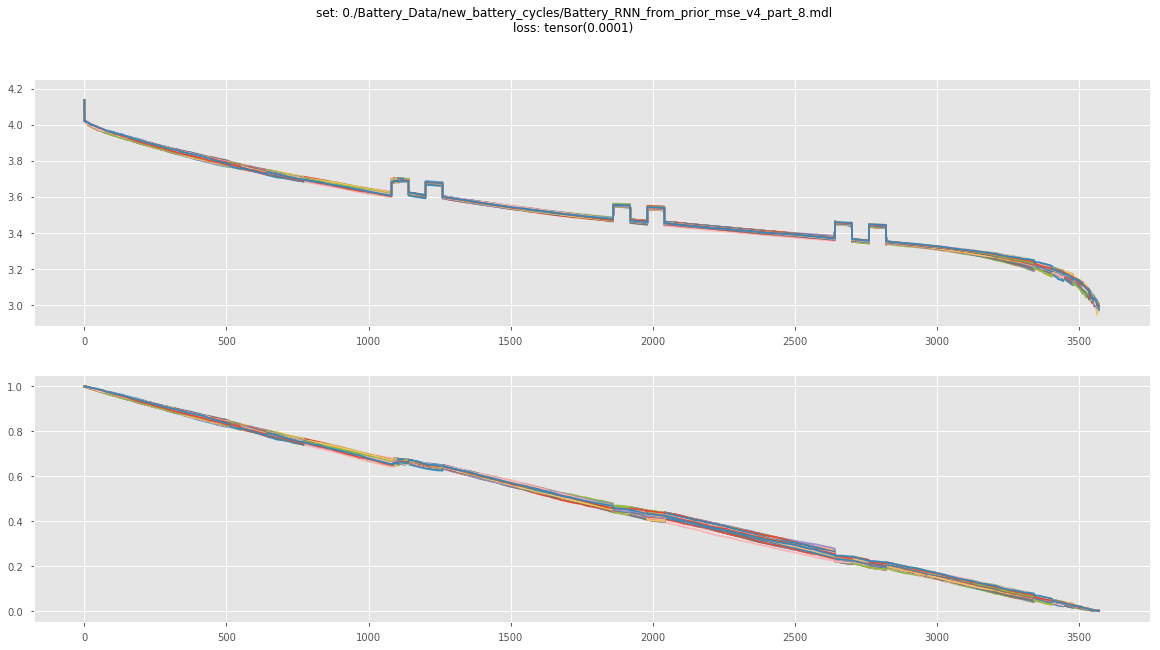

torch.Size([100, 1852])
(1, 1852)


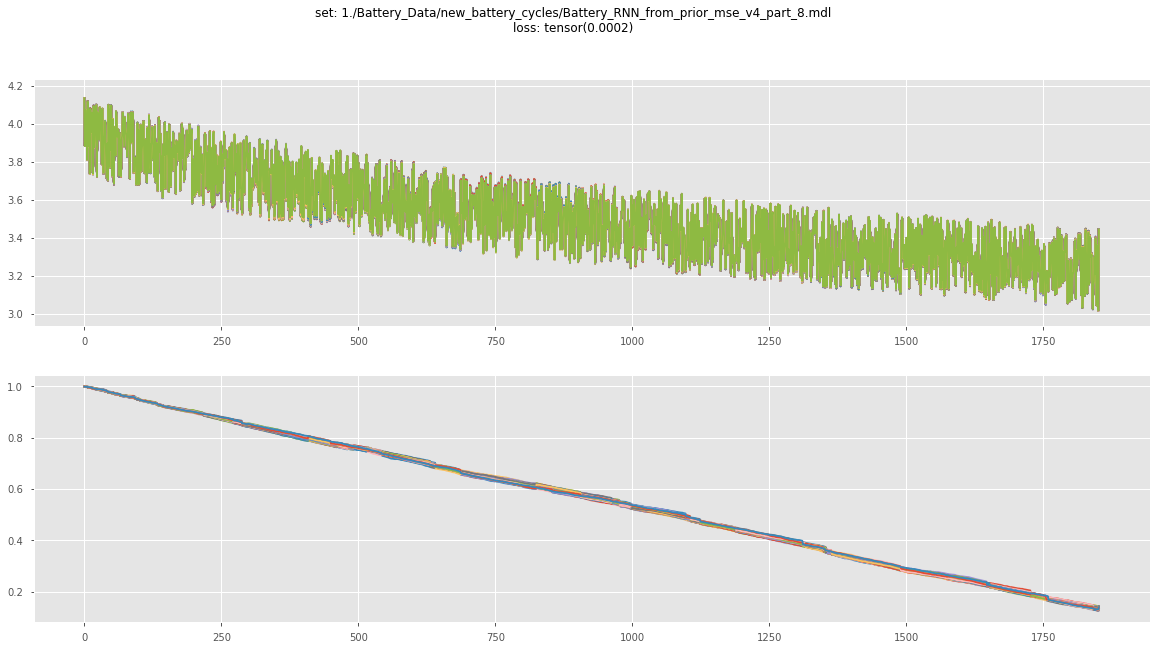

torch.Size([100, 1849])
(1, 1849)


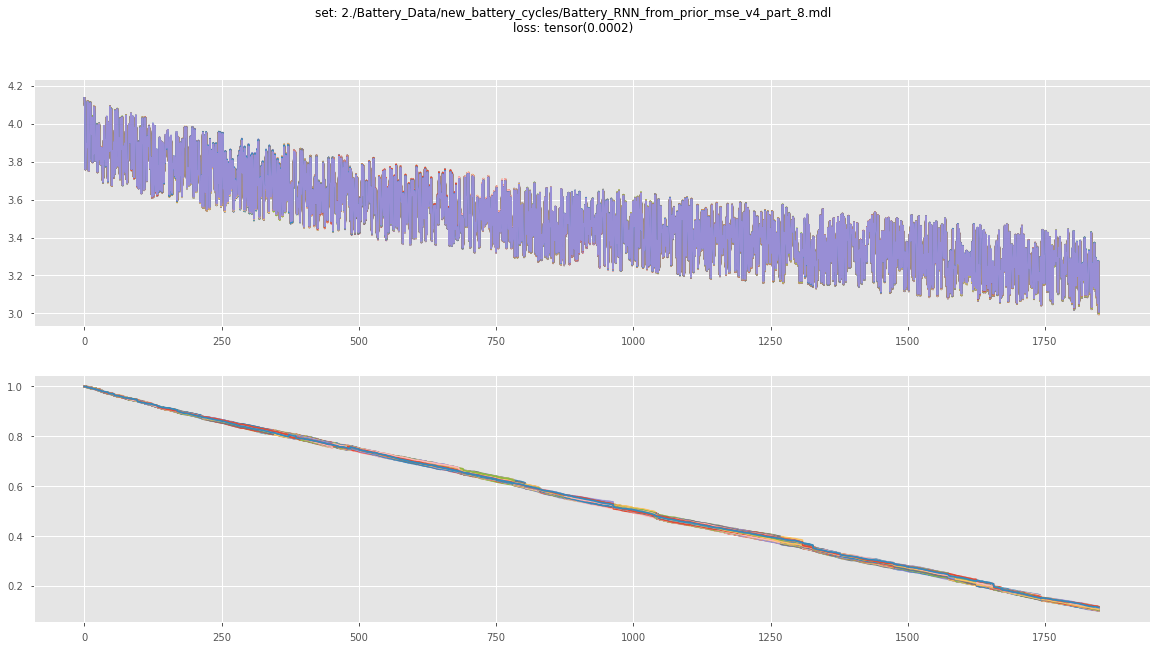

torch.Size([100, 3570])
(1, 3570)


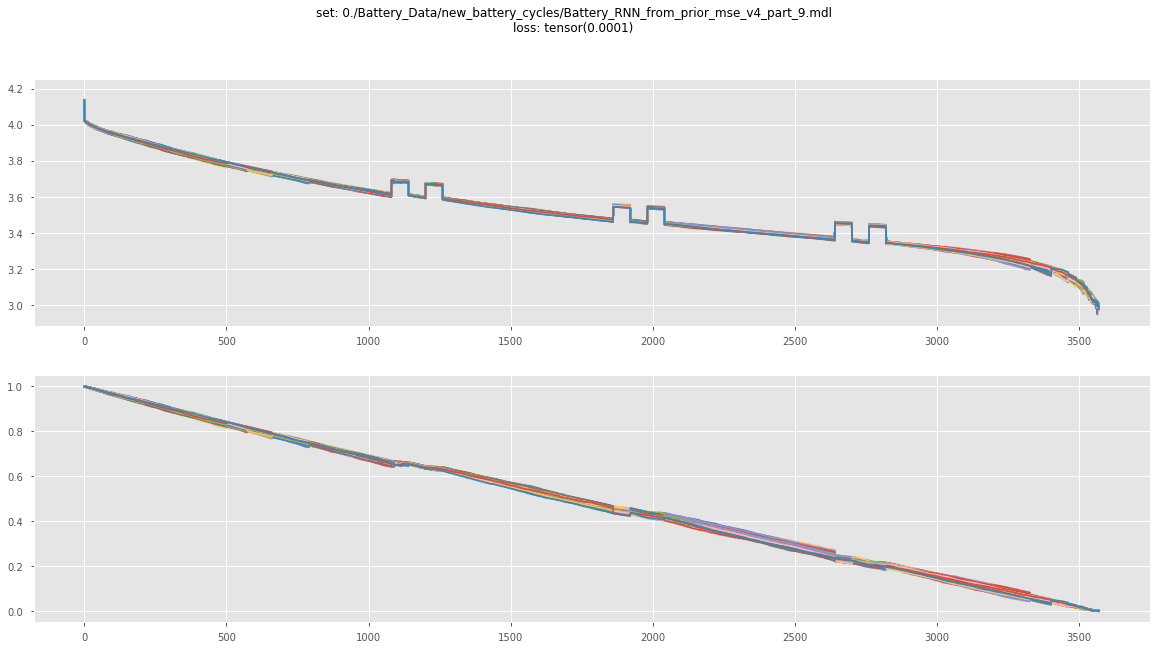

torch.Size([100, 1852])
(1, 1852)


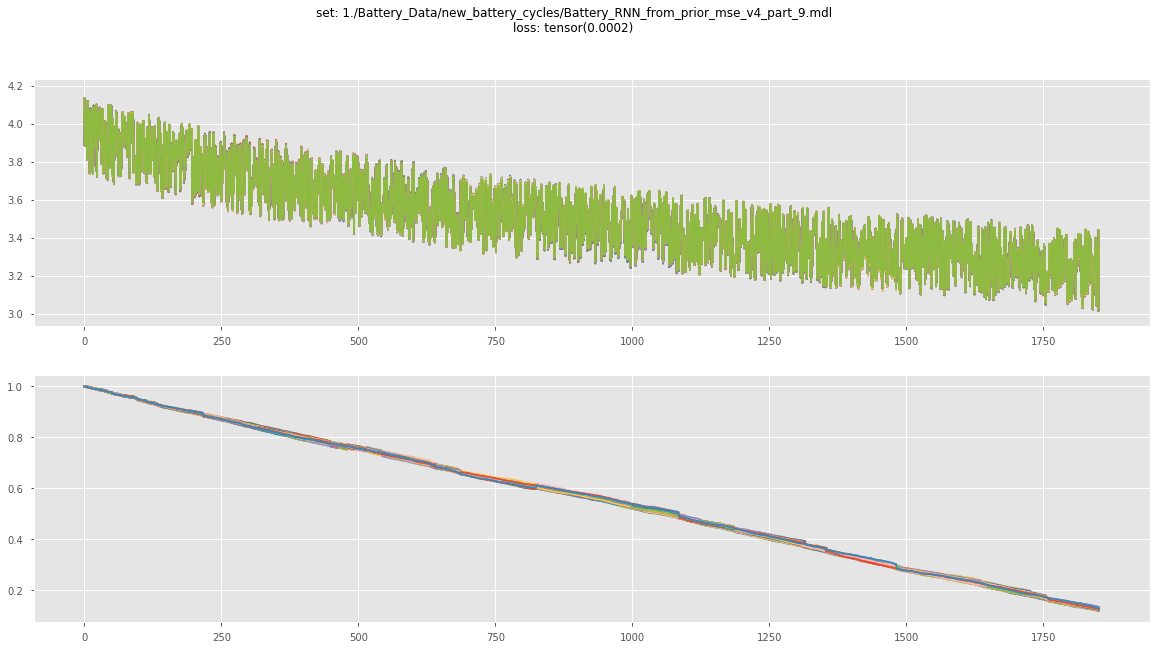

torch.Size([100, 1849])
(1, 1849)


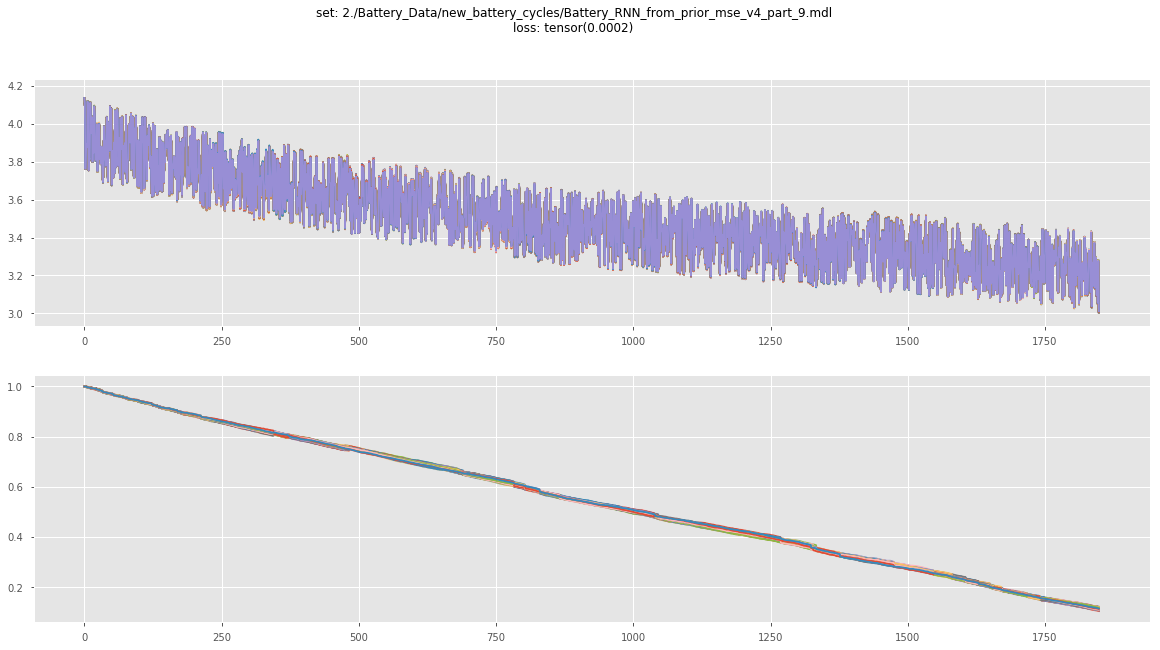

torch.Size([100, 3570])
(1, 3570)


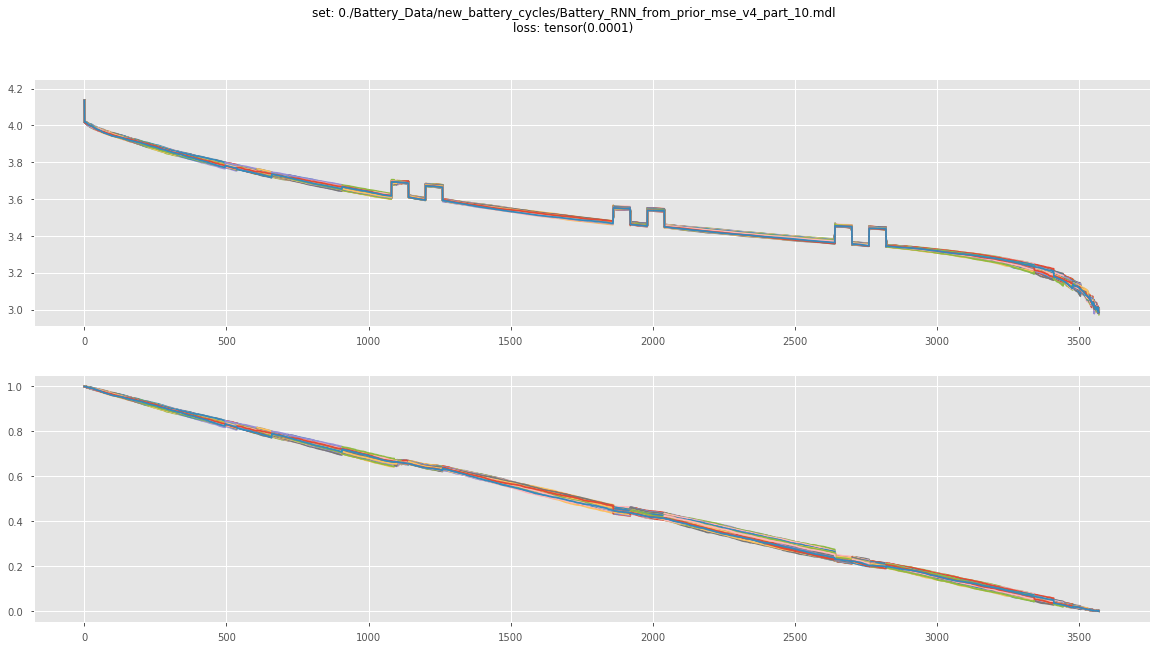

torch.Size([100, 1852])
(1, 1852)


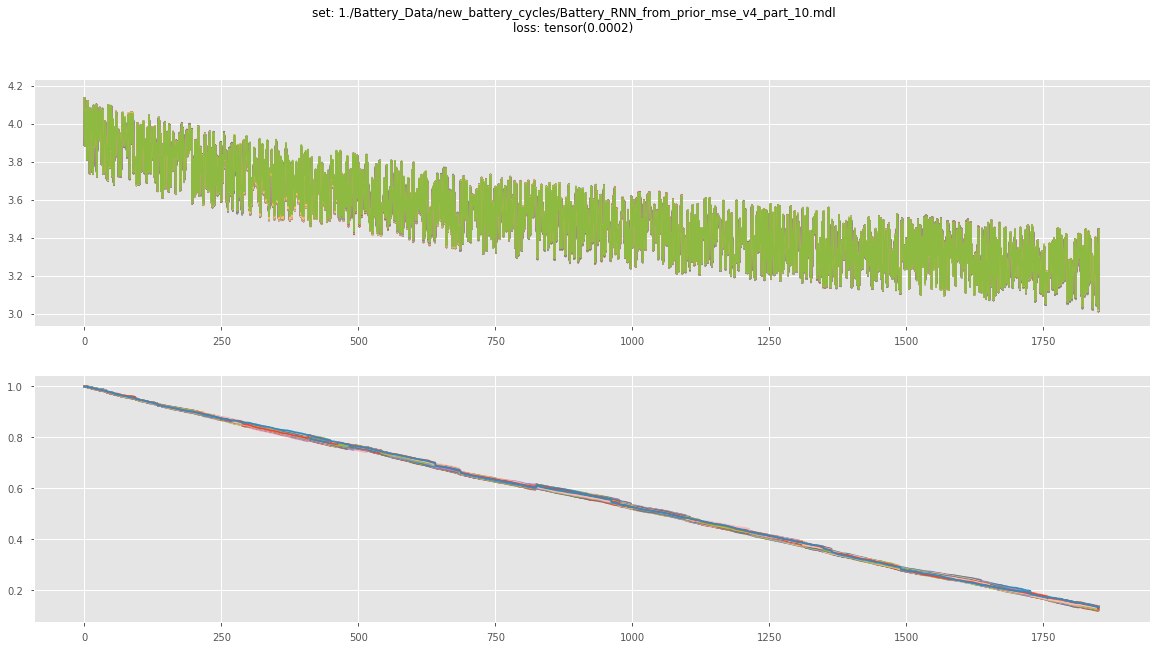

torch.Size([100, 1849])
(1, 1849)


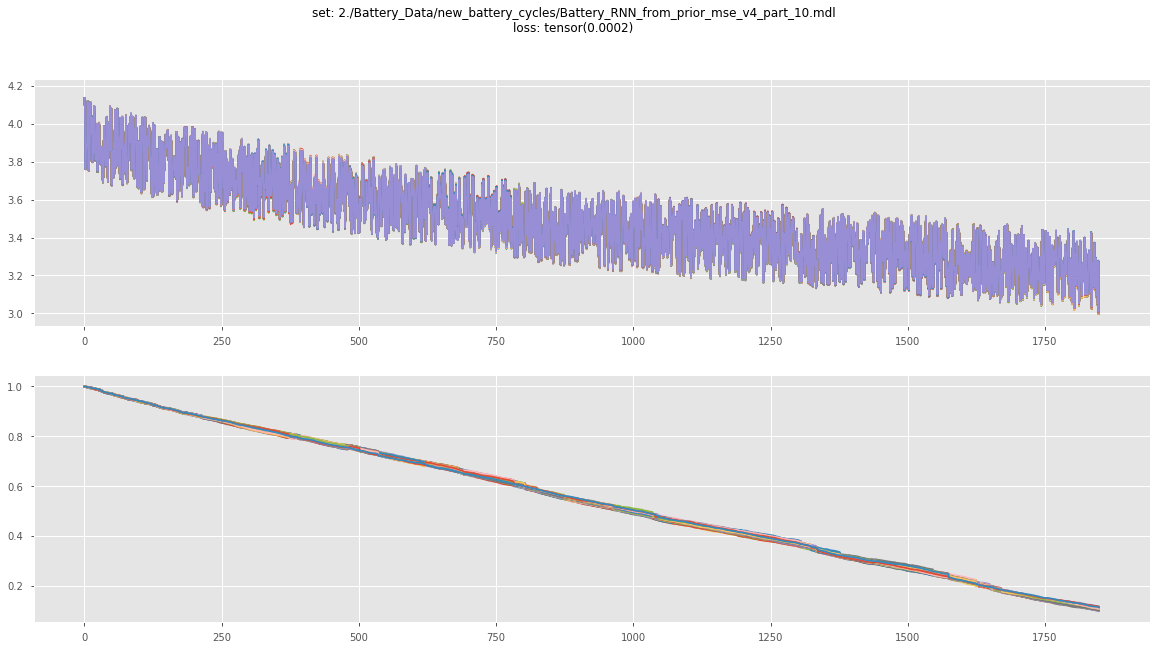

In [6]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
for i in range(0, parts):
    saved = "{0}_part_{1}.mdl".format(saved_network, i+1)
    with torch.no_grad():
        vsmc.load_state_dict(torch.load(saved))
        vsmc.to(device)
        for j, set_dict in enumerate(Characterisation_Set['Sets']):
            state = torch.ones(N, 1) * 1.0
            loss, voltage, soc_hist = vsmc(state, set_dict['Current'], set_dict['Voltage'])
            print(voltage.shape)
            print(set_dict['Voltage'].shape)
            plt.figure()
            plt.suptitle("set: " + str(j) + saved + "\nloss: " + str(loss))
            plt.subplot(211)
            plt.plot(set_dict['Voltage'])
            plt.plot(voltage.numpy().T)
            plt.subplot(212)
            plt.plot(soc_hist.numpy().T)
            plt.show()